- 프로젝트 정리
  - AutoML은 빼고 생각을 해보자
  - optuna를 사용해보지만 하이퍼파라미터는 grid search 등을 이용해서 찾아내자
  - 모든 팀원은 시드값을 바꿔서 예측한다.

In [195]:
# import matplotlib as plt
# plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지
# # 한글 폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic') # 폰트 적용

In [196]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [197]:
train_ft = pd.read_csv('train.csv')
test_ft = pd.read_csv('test.csv')

target = train_ft['대출등급']

train_ft = train_ft.iloc[:,1:-1].copy()
test_ft = test_ft.iloc[:,1:].copy()

train_ft.shape,test_ft.shape

((96294, 13), (64197, 13))

In [198]:
train_ft.loc[train_ft['근로기간']=='3','근로기간']='3 years'
test_ft.loc[test_ft['근로기간']=='3','근로기간']='3 years'
test_ft.loc[test_ft['근로기간']=='1 year','근로기간']='1 years'
train_ft.loc[train_ft['근로기간']=='1 year','근로기간']='1 years'
test_ft.loc[test_ft['근로기간']=='<1 year','근로기간']='< 1 year'
train_ft.loc[train_ft['근로기간']=='<1 year','근로기간']='< 1 year'
test_ft.loc[test_ft['근로기간']=='10+years','근로기간']='10+ years'
train_ft.loc[train_ft['근로기간']=='10+years','근로기간']='10+ years'
test_ft.loc[test_ft['근로기간']=='Unknown','근로기간']='10+ years'
train_ft.loc[train_ft['근로기간']=='Unknown','근로기간']='10+ years'

values_map=dict({'6 years':6,
 '10+ years':10,
 '5 years':5,
 '8 years':8,
 '9 years':9,
 '2 years':2,
 '1 years':1,
 '3 years':3,
 '7 years':7,
 '4 years':4,
 '< 1 year':0,
 })

train_ft['근로기간']=train_ft['근로기간'].map(values_map)
test_ft['근로기간']=test_ft['근로기간'].map(values_map)

In [199]:
train_ft

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,36 months,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0
1,14400000,60 months,10,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0
2,12000000,36 months,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0
3,14400000,36 months,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0
4,18000000,60 months,10,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0
96290,28800000,60 months,10,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0
96291,14400000,36 months,1,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0
96292,15600000,36 months,5,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0


# 데이터 분석

In [200]:
train_ft['근로기간'].value_counts()

# 근로기간에 잘못 라벨링된 것들이 존재함.

근로기간
10    38152
2      8450
0      8144
3      7670
1      6305
5      5665
4      5588
8      4888
6      3874
7      3814
9      3744
Name: count, dtype: int64

In [201]:
train_ft['주택소유상태'].value_counts()
train_ft[train_ft['주택소유상태'] == 'ANY']

# any는 무엇인가?
# 가장 빈도수가 높은 부분에 any를 넣어준다.

train_ft['주택소유상태'] = train_ft['주택소유상태'].replace('ANY','MORTGAGE')
train_ft['주택소유상태'].value_counts()

주택소유상태
MORTGAGE    47935
RENT        37705
OWN         10654
Name: count, dtype: int64

In [202]:
train_ft['대출목적'].value_counts()

대출목적
부채 통합     55150
신용 카드     24500
주택 개선      6160
기타         4725
주요 구매      1803
의료         1039
자동차         797
소규모 사업      787
이사          506
휴가          466
주택          301
재생 에너지       60
Name: count, dtype: int64

In [203]:
train_ft['대출기간'] = train_ft['대출기간'].str.strip().replace('months', '', regex=True).astype(float)
test_ft['대출기간'] = test_ft['대출기간'].str.strip().replace('months', '', regex=True).astype(float)

## 대출금액 특징 추출

In [204]:
# 대출금액 / 연간소득

train_ft['연간소득_대비_대출금액'] = train_ft['대출금액'] / train_ft['연간소득']
test_ft['연간소득_대비_대출금액'] = test_ft['대출금액'] / train_ft['연간소득']

train_ft.shape,test_ft.shape

((96294, 14), (64197, 14))

In [205]:
tmp_max = train_ft['연간소득_대비_대출금액'].replace(np.inf,np.nan).max()
# np.inf를 제외한 최대 값은 10에 해당한다.
# test_ft['연간소득_대비_대출금액'].replace(np.inf,np.nan).max()
# np.inf를 제외한 최대 값은 6.481481481481482에 해당한다.

train_ft['연간소득_대비_대출금액'] = train_ft['연간소득_대비_대출금액'].replace(np.inf,tmp_max)
test_ft['연간소득_대비_대출금액'] = test_ft['연간소득_대비_대출금액'].replace(np.inf,tmp_max)

train_ft['연간소득_대비_대출금액'].max(),test_ft['연간소득_대비_대출금액'].max()

(10.0, 10.0)

In [206]:
# 총상환원금 / 대출금액

train_ft['대출금액_대비_총상환원금'] = train_ft['총상환원금'] / train_ft['대출금액']
test_ft['대출금액_대비_총상환원금'] = test_ft['총상환원금'] / test_ft['대출금액']

train_ft.shape,test_ft.shape

((96294, 15), (64197, 15))

In [207]:
SEED = 38

In [208]:
# 총상환이자 / 대출금액
# (train_ft['총상환이자'] / train_ft['대출금액']).head()
# keep

train_ft['대출금액_대비_총상환이자'] = train_ft['총상환이자'] / train_ft['대출금액']
test_ft['대출금액_대비_총상환이자'] = test_ft['총상환이자'] / test_ft['대출금액']

In [209]:
# 총연체금액 / 대출금액
# (train_ft['총연체금액'] / train_ft['대출금액']).head()

train_ft['대출금액_대비_총연체금액'] = train_ft['총연체금액'] / train_ft['대출금액']
test_ft['대출금액_대비_총연체금액'] = test_ft['총연체금액'] / test_ft['대출금액']

train_ft.shape,test_ft.shape

((96294, 17), (64197, 17))

In [210]:
def calculate_altman_z_score(row):
    # 각 피처의 비율 계산
    working_capital_ratio = row['근로기간'] / row['대출금액']
    retained_earnings_ratio = row['총상환원금'] / row['대출금액']
    total_accounts_ratio = row['총계좌수'] / row['대출금액']
    delinquent_accounts_ratio = row['연체계좌수'] / row['대출금액']
    total_delinquency_ratio = row['총연체금액'] / row['대출금액']

    # Altman Z-Score 계산
    altman_z_score = 1.2 * working_capital_ratio + 1.4 * retained_earnings_ratio + 3.3 * total_accounts_ratio + 0.6 * delinquent_accounts_ratio + 1.0 * total_delinquency_ratio

    return altman_z_score


train_ft['Altman_Z_Score'] = train_ft.apply(calculate_altman_z_score, axis=1)
test_ft['Altman_Z_Score'] = test_ft.apply(calculate_altman_z_score, axis=1)

train_ft.shape, test_ft.shape

((96294, 18), (64197, 18))

In [211]:
# 대출금액 분위수 설정
q1,q3 = train_ft['대출금액'].quantile([0.25,0.75])
iqr = q3 - q1
w = 1.5
box_min = q1 - iqr * w
box_max = q3 + iqr * w

def boxplot(x):
    if x < box_min or x >= box_max:
        return 0 # x가 이상치의 경우에는 0으로 설정해준다.
    elif box_min <= x < q1:
        return 1  # x가 Q1보다 크거나 같고 Q1보다 작은 경우
    elif q1 <= x < q3:
        return 2  # x가 Q1 이상이고 Q3 미만인 경우
    elif q3 <= x < box_max:
        return 3  # x가 Q3 이상이고 box_max 미만인 경우
    else:
        return 'Undefined'

train_ft['대출금액_분위수'] = train_ft['대출금액'].apply(boxplot)
test_ft['대출금액_분위수'] = test_ft['대출금액'].apply(boxplot)

train_ft.shape,test_ft.shape

# 연간소득의 분위수 설정

((96294, 19), (64197, 19))

In [212]:
# 연체계좌수 / 대출금액
# (train_ft['연체계좌수'] / train_ft['대출금액']).head()

# train_ft['대출금액_대비_연체계좌수'] = train_ft['연체계좌수'] / train_ft['대출금액']
# test_ft['대출금액_대비_연체계좌수'] = test_ft['연체계좌수'] / test_ft['대출금액']
#
# train_ft.shape,test_ft.shape

## DTI

In [213]:
# 대출금액과 대출기간을 활용하여 월별 상환금 계산
train_ft['월별상환금'] = train_ft['대출금액'] / train_ft['대출기간']

# 근사적인 DTI 계산
train_ft['DTI'] = (train_ft['월별상환금'] * 12) / (train_ft['연간소득'] * (train_ft['부채_대비_소득_비율'] / 100))

# 대출금액과 대출기간을 활용하여 월별 상환금 계산
test_ft['월별상환금'] = test_ft['대출금액'] / test_ft['대출기간']

# 근사적인 DTI 계산
test_ft['DTI'] = (test_ft['월별상환금'] * 12) / (test_ft['연간소득'] * (test_ft['부채_대비_소득_비율'] / 100))

train_ft['DTI'] = train_ft['DTI'].replace(np.inf,0)
test_ft['DTI'] = test_ft['DTI'].replace(np.inf,0)

## 부채금액 특징 추출

In [214]:
train_ft['부채금액_2'] = train_ft['대출금액'] - train_ft['총상환원금']

In [215]:
test_ft['부채금액_2'] = test_ft['대출금액'] - test_ft['총상환원금']

In [216]:
# 부채_대비_소득_비율을 통해 부채 총 금액 설정
# 분자에 오는 소득이 월단위 소득인지 년 단위 소득인지 애매함.
# 우선 연간소득으로 부채를 구함
# keep

train_ft['부채금액'] = train_ft['연간소득'] / (train_ft['부채_대비_소득_비율'] / 100)
test_ft['부채금액'] = test_ft['연간소득'] / (test_ft['부채_대비_소득_비율'] / 100)

train_ft.shape,test_ft.shape

((96294, 23), (64197, 23))

In [217]:
# train_ft['부채_대비_소득_비율']에 0이 존재
dept_max = train_ft['부채금액'].replace(np.inf,np.nan).max()
train_ft['부채금액'] = train_ft['부채금액'].replace(np.inf,dept_max)

# dept_max = test_ft['부채금액'].replace(np.inf,np.nan).max()
test_ft['부채금액'] = test_ft['부채금액'].replace(np.inf,dept_max)

train_ft['부채금액'].max(),test_ft['부채금액'].max()

(13500000000000.0, 13500000000000.0)

In [218]:
# 대출금액 / 부채금액
# 부채에서 대출이 차지하는 비율
# (train_ft['대출금액'] / train_ft['부채금액']).head()
# keep

train_ft['부채금액_대비_대출금액'] = train_ft['대출금액'] / train_ft['부채금액']
test_ft['부채금액_대비_대출금액'] = test_ft['대출금액'] / test_ft['부채금액']

train_ft.shape,test_ft.shape

((96294, 24), (64197, 24))

In [219]:
temp_max = train_ft['부채금액_대비_대출금액'].replace(np.inf,np.nan).max()
train_ft['부채금액_대비_대출금액'] = train_ft['부채금액_대비_대출금액'].replace(np.inf,temp_max)

# temp_max = test_ft['부채금액_대비_대출금액'].replace(np.inf,np.nan).max()
test_ft['부채금액_대비_대출금액'] = test_ft['부채금액_대비_대출금액'].replace(np.inf,temp_max)

train_ft['부채금액_대비_대출금액'].max(),test_ft['부채금액_대비_대출금액'].max()

(67.25200000000001, 67.25200000000001)

In [220]:
# 최근_2년간_연체_횟수 / 부채금액

# train_ft['부채금액_대비_연체횟수'] = train_ft['최근_2년간_연체_횟수'] / train_ft['부채금액']
# test_ft['부채금액_대비_연체횟수'] = test_ft['최근_2년간_연체_횟수'] / test_ft['부채금액']
#
# train_ft.shape,test_ft.shape

In [221]:
# temp_max = train_ft['부채금액_대비_연체횟수'].replace(np.inf,np.nan).max()
# train_ft['부채금액_대비_연체횟수'] = train_ft['부채금액_대비_연체횟수'].replace(np.inf,temp_max)
#
# temp_max = test_ft['부채금액_대비_연체횟수'].replace(np.inf,np.nan).max()
# test_ft['부채금액_대비_연체횟수'] = test_ft['부채금액_대비_연체횟수'].replace(np.inf,temp_max)
#
# train_ft['부채금액_대비_연체횟수'].max(),test_ft['부채금액_대비_연체횟수'].max()

In [222]:
# train_ft['부채금액_대비_연체횟수'].fillna(0,inplace = True)
# test_ft['부채금액_대비_연체횟수'].fillna(0,inplace = True)

## 연간소득 특징 추출

In [223]:
# 연간소득의 분위수 설정
# boxplot은 위에 있는 함수 그대로 사용하면 됩니다.

q1,q3 = train_ft['연간소득'].quantile([0.25,0.75])
iqr = q3 - q1
w = 1.5
box_min = q1 - iqr * w
box_max = q3 + iqr * w

train_ft['연간소득_분위수'] = train_ft['연간소득'].apply(boxplot)
test_ft['연간소득_분위수'] = test_ft['연간소득'].apply(boxplot)

train_ft.shape,test_ft.shape

((96294, 25), (64197, 25))

In [224]:
# 총상황원금 / 연간소득
# (train_ft['총상환원금'] / train_ft['연간소득']).head()
# keep

train_ft['연간소득_대비_총상환원금'] = train_ft['총상환원금'] / train_ft['연간소득']
test_ft['연간소득_대비_총상환원금'] = test_ft['총상환원금'] / test_ft['연간소득']

train_ft.shape,test_ft.shape

((96294, 26), (64197, 26))

In [225]:
temp_max = train_ft['연간소득_대비_총상환원금'].replace(np.inf,np.nan).max()
train_ft['연간소득_대비_총상환원금'] = train_ft['연간소득_대비_총상환원금'].replace(np.inf,temp_max)

# temp_max = test_ft['연간소득_대비_총상환원금'].replace(np.inf,np.nan).max()
test_ft['연간소득_대비_총상환원금'] = test_ft['연간소득_대비_총상환원금'].replace(np.inf,temp_max)

train_ft['연간소득_대비_총상환원금'].max(),test_ft['연간소득_대비_총상환원금'].max()

(0.4276465, 0.4276465)

In [226]:
# 총상환이자 / 연간소득
# keep

train_ft['연간소득_대비_총상환이자'] = train_ft['총상환이자'] / train_ft['연간소득']
test_ft['연간소득_대비_총상환이자'] = test_ft['총상환이자'] / test_ft['연간소득']

train_ft.shape,test_ft.shape

((96294, 27), (64197, 27))

In [227]:
temp_max = train_ft['연간소득_대비_총상환이자'].replace(np.inf,np.nan).max()
train_ft['연간소득_대비_총상환이자'] = train_ft['연간소득_대비_총상환이자'].replace(np.inf,temp_max)

# temp_max = test_ft['연간소득_대비_총상환이자'].replace(np.inf,np.nan).max()
test_ft['연간소득_대비_총상환이자'] = test_ft['연간소득_대비_총상환이자'].replace(np.inf,temp_max)

train_ft['연간소득_대비_총상환이자'].max(),test_ft['연간소득_대비_총상환이자'].max()

(0.30754166666666666, 0.30754166666666666)

In [228]:
# 총연체금액 / 연간소득
# 연체 금액 자체는 좋은 특징을 못 뽑아내는 듯

# train_ft['연간소득_대비_총연체금액'] = train_ft['총연체금액'] / train_ft['연간소득']
# test_ft['연간소득_대비_총연체금액'] = test_ft['총연체금액'] / test_ft['연간소득']

# train_ft.shape,test_ft.shape

#train_ft.shape,test_ft.shape

In [229]:
# train_ft['연간소득_대비_총연체금액'].fillna(0,inplace = True)
# test_ft['연간소득_대비_총연체금액'].fillna(0,inplace = True)

In [230]:
# 연체계좌수 / 연간소득

train_ft['연간소득_대비_연체계좌수'] = train_ft['연체계좌수'] / train_ft['연간소득']
test_ft['연간소득_대비_연체계좌수'] = test_ft['연체계좌수'] / test_ft['연간소득']

train_ft.shape,test_ft.shape

((96294, 28), (64197, 28))

In [231]:
train_ft['연간소득_대비_연체계좌수'].fillna(0,inplace = True)
test_ft['연간소득_대비_연체계좌수'].fillna(0,inplace = True)

In [232]:
# 최근_2년간_연체_횟수 / 연간소득
# (train_ft['최근_2년간_연체_횟수'] / train_ft['연간소득']).head()
# keep

train_ft['연간소득_대비_연체횟수'] = train_ft['최근_2년간_연체_횟수'] / train_ft['연간소득']
test_ft['연간소득_대비_연체횟수'] = test_ft['최근_2년간_연체_횟수'] / test_ft['연간소득']

train_ft.shape, test_ft.shape

((96294, 29), (64197, 29))

In [233]:
train_ft['연간소득_대비_연체횟수'].fillna(0,inplace = True)
test_ft['연간소득_대비_연체횟수'].fillna(0,inplace = True)

In [234]:
temp_max = train_ft['연간소득_대비_연체횟수'].replace(np.inf,np.nan).max()
train_ft['연간소득_대비_연체횟수'] = train_ft['연간소득_대비_연체횟수'].replace(np.inf,temp_max)

train_ft['연간소득_대비_연체횟수'].max(),test_ft['연간소득_대비_연체횟수'].max()

(9.416195856873823e-07, 4.032258064516129e-07)

In [235]:
# 총계좌수 / 연간소득
# (train_ft['총계좌수'] / train_ft['연간소득']).head()
# keep

train_ft['연간소득_대비_총계좌수'] = train_ft['총계좌수'] / train_ft['연간소득']
test_ft['연간소득_대비_총계좌수'] = test_ft['총계좌수'] / test_ft['연간소득']

train_ft.shape, test_ft.shape

((96294, 30), (64197, 30))

In [236]:
temp_max = train_ft['연간소득_대비_총계좌수'].replace(np.inf,np.nan).max()
train_ft['연간소득_대비_총계좌수'] = train_ft['연간소득_대비_총계좌수'].replace(np.inf,temp_max)

# temp_max = test_ft['연간소득_대비_총계좌수'].replace(np.inf,np.nan).max()
test_ft['연간소득_대비_총계좌수'] = test_ft['연간소득_대비_총계좌수'].replace(np.inf,temp_max)

train_ft['연간소득_대비_총계좌수'].max(),test_ft['연간소득_대비_총계좌수'].max()

(1.1770244821092279e-05, 1.1770244821092279e-05)

## 총상환원금

In [237]:
# 총상환원금 / 총상환이자
# (train_ft['총상환원금'] / train_ft['총상환이자']).head()
# keep

train_ft['총상환이자_대비_총상환원금'] = train_ft['총상환원금'] / train_ft['총상환이자']
test_ft['총상환이자_대비_총상환원금'] = test_ft['총상환원금'] / test_ft['총상환이자']

train_ft.shape, test_ft.shape

((96294, 31), (64197, 31))

In [238]:
train_ft['총상환이자_대비_총상환원금'].fillna(0,inplace = True)
test_ft['총상환이자_대비_총상환원금'].fillna(0,inplace = True)

In [239]:
temp_max = train_ft['총상환이자_대비_총상환원금'].replace(np.inf,np.nan).max()
train_ft['총상환이자_대비_총상환원금'] = train_ft['총상환이자_대비_총상환원금'].replace(np.inf,temp_max)

# temp_max = test_ft['총상환이자_대비_총상환원금'].replace(np.inf,np.nan).max()
test_ft['총상환이자_대비_총상환원금'] = test_ft['총상환이자_대비_총상환원금'].replace(np.inf,temp_max)

train_ft['총상환이자_대비_총상환원금'].max(),test_ft['총상환이자_대비_총상환원금'].max()

(1084.9701657458563, 1084.9701657458563)

In [240]:
# 총연체금액 / 총상환원금
# 총연체금액에 대해서 집착을 버리는 게 좋을 것 같긴 함.

train_ft['총상환원금_대비_총연체금액'] = train_ft['총연체금액'] / train_ft['총상환원금']
test_ft['총상환원금_대비_총연체금액'] = test_ft['총연체금액'] / test_ft['총상환원금']

train_ft.shape, test_ft.shape

((96294, 32), (64197, 32))

In [241]:
train_ft['총상환원금_대비_총연체금액'].fillna(0,inplace = True)
test_ft['총상환원금_대비_총연체금액'].fillna(0,inplace = True)

In [242]:
temp_max = train_ft['총상환원금_대비_총연체금액'].replace(np.inf,np.nan).max()
train_ft['총상환원금_대비_총연체금액'] = train_ft['총상환원금_대비_총연체금액'].replace(np.inf,temp_max)

# temp_max = test_ft['총상환원금_대비_총연체금액'].replace(np.inf,np.nan).max()
test_ft['총상환원금_대비_총연체금액'] = test_ft['총상환원금_대비_총연체금액'].replace(np.inf,temp_max)

train_ft['총상환원금_대비_총연체금액'].max(),test_ft['총상환원금_대비_총연체금액'].max()

(0.36023054755043227, 0.36023054755043227)

In [243]:
# keep
train_ft['총상환원금_대비_총계좌수'] = train_ft['총계좌수'] / train_ft['총상환원금']
test_ft['총상환원금_대비_총계좌수'] = test_ft['총계좌수'] / test_ft['총상환원금']

train_ft.shape,test_ft.shape

((96294, 33), (64197, 33))

In [244]:
temp_max = train_ft['총상환원금_대비_총계좌수'].replace(np.inf,np.nan).max()
train_ft['총상환원금_대비_총계좌수'] = train_ft['총상환원금_대비_총계좌수'].replace(np.inf,temp_max)

# temp_max = test_ft['총상환원금_대비_총계좌수'].replace(np.inf,np.nan).max()
test_ft['총상환원금_대비_총계좌수'] = test_ft['총상환원금_대비_총계좌수'].replace(np.inf,temp_max)

train_ft['총상환원금_대비_총계좌수'].max(),test_ft['총상환원금_대비_총계좌수'].max()

(0.06862745098039216, 0.06862745098039216)

## 대출금액_대비_총상환원금

In [245]:
# keep

train_ft['대출금액_대비_총상환원금 / 총계좌수'] = train_ft['대출금액_대비_총상환원금'] / train_ft['총계좌수']
test_ft['대출금액_대비_총상환원금 / 총계좌수'] = test_ft['대출금액_대비_총상환원금'] / test_ft['총계좌수']

In [246]:
train_ft['대출금액_대비_총상환원금 / 총계좌수'].max(),test_ft['대출금액_대비_총상환원금 / 총계좌수'].max()

(0.16666666666666666, 0.19345238095238096)

In [247]:
train_ft.isnull().sum()

대출금액                    0
대출기간                    0
근로기간                    0
주택소유상태                  0
연간소득                    0
부채_대비_소득_비율             0
총계좌수                    0
대출목적                    0
최근_2년간_연체_횟수            0
총상환원금                   0
총상환이자                   0
총연체금액                   0
연체계좌수                   0
연간소득_대비_대출금액            0
대출금액_대비_총상환원금           0
대출금액_대비_총상환이자           0
대출금액_대비_총연체금액           0
Altman_Z_Score          0
대출금액_분위수                0
월별상환금                   0
DTI                     0
부채금액_2                  0
부채금액                    0
부채금액_대비_대출금액            0
연간소득_분위수                0
연간소득_대비_총상환원금           0
연간소득_대비_총상환이자           0
연간소득_대비_연체계좌수           0
연간소득_대비_연체횟수            0
연간소득_대비_총계좌수            0
총상환이자_대비_총상환원금          0
총상환원금_대비_총연체금액          0
총상환원금_대비_총계좌수           0
대출금액_대비_총상환원금 / 총계좌수    0
dtype: int64

## 새로운 피처 추가

In [248]:
train_ft.columns

Index(['대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수', '대출목적',
       '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '연간소득_대비_대출금액',
       '대출금액_대비_총상환원금', '대출금액_대비_총상환이자', '대출금액_대비_총연체금액', 'Altman_Z_Score',
       '대출금액_분위수', '월별상환금', 'DTI', '부채금액_2', '부채금액', '부채금액_대비_대출금액',
       '연간소득_분위수', '연간소득_대비_총상환원금', '연간소득_대비_총상환이자', '연간소득_대비_연체계좌수',
       '연간소득_대비_연체횟수', '연간소득_대비_총계좌수', '총상환이자_대비_총상환원금', '총상환원금_대비_총연체금액',
       '총상환원금_대비_총계좌수', '대출금액_대비_총상환원금 / 총계좌수'],
      dtype='object')

In [249]:
train_ft['총상환률'] = (train_ft['총상환원금'] + train_ft['총상환이자']) / train_ft['대출금액']
test_ft['총상환률'] = (test_ft['총상환원금'] + test_ft['총상환이자']) / test_ft['대출금액']

train_ft.shape,test_ft.shape

((96294, 35), (64197, 35))

In [250]:
# 고객별 연체의 심각성을 수치로 표현해줌
# 이거 빼니깐 오히려 점수 올라감

# train_ft['가중_연체_점수'] = train_ft['최근_2년간_연체_횟수'] * train_ft['총연체금액'] * train_ft['연체계좌수']
# test_ft['가중_연체_점수'] = test_ft['최근_2년간_연체_횟수'] * test_ft['총연체금액'] * test_ft['연체계좌수']

train_ft.shape,test_ft.shape

((96294, 35), (64197, 35))

In [251]:
# 금융안정지수
# 대출 기간 동안의 재정적 안성성에 대한 상대적 척도를 제공한다.
# 차용인이 가지고 있는 걔좌 수를 고려하고 돈을 얼마나 벌고 갚았는지를 살펴보는 지표인 것이다.

train_ft['금융안정지수'] = (train_ft['연간소득'] + train_ft['총상환원금']) / (train_ft['총계좌수'] * train_ft['대출금액'])
test_ft['금융안정지수'] = (test_ft['연간소득'] + test_ft['총상환원금']) / (test_ft['총계좌수'] * test_ft['대출금액'])

train_ft.shape,test_ft.shape

((96294, 36), (64197, 36))

In [252]:
train_ft['대출기간']

0        36.0
1        60.0
2        36.0
3        36.0
4        60.0
         ... 
96289    36.0
96290    60.0
96291    36.0
96292    36.0
96293    36.0
Name: 대출기간, Length: 96294, dtype: float64

In [253]:
# 재연님 코드 참고

#대출금액과 대출기간을 활용하여 월별 상환금 계산
train_ft['월별상환금'] = train_ft['대출금액'] / train_ft['대출기간']

# 근사적인 DTI 계산
train_ft['DTI'] = (train_ft['월별상환금'] * 12) / (train_ft['연간소득'] * (train_ft['부채_대비_소득_비율'] / 100))

# 근사적인 DTI 계산
test_ft['월별상환금'] = test_ft['대출금액'] / test_ft['대출기간']

# 근사적인 DTI 계산
test_ft['DTI'] = (test_ft['월별상환금'] * 12) / (test_ft['연간소득'] * (test_ft['부채_대비_소득_비율'] / 100))

test_ft['DTI'].max(),train_ft['DTI'].max()

(inf, inf)

In [254]:
train_ft['DTI'] = train_ft['DTI'].replace(np.inf,0)
test_ft['DTI'] = test_ft['DTI'].replace(np.inf,0)

In [255]:
# train_ft.drop(columns = ['부채_보장_지수'],inplace = True)
# test_ft.drop(columns = ['부채_보장_지수'],inplace = True)

In [256]:
# 부채 보장 지수
# 부채 보장 지수가 높을수록 상환 의무를 충당하기 위한 차용인의 소득 능력이 더 우수하다는 것을 의미할 수 있습니다.
# train_ft['부채_보장_지수'] = (train_ft['연간소득'] - train_ft['DTI']) / train_ft['총상환원금']
# test_ft['부채_보장_지수'] = (test_ft['연간소득'] - test_ft['DTI']) / test_ft['총상환원금']

# train_ft.shape, test_ft.shape

In [257]:
# # temp_max = train_ft['부채_보장_지수'].replace(np.inf,np.nan).max()
# train_ft['부채_보장_지수'] = train_ft['부채_보장_지수'].replace(np.inf,temp_max)
#
# # temp_max = test_ft['신용활용지수'].replace(np.inf,np.nan).max()
# test_ft['부채_보장_지수'] = test_ft['부채_보장_지수'].replace(np.inf,temp_max)
#
# train_ft['부채_보장_지수'].max(),test_ft['부채_보장_지수'].max()

In [258]:
# 재정 건강 점수
# 소득이 높고 부채 비율이 낮으며 금융 계정의 다양성이 높은 차용자에게 더 높은 점수르 제공하여 잠재적으로 더 나은 재무 건정성을 나타냅니다.

train_ft['재정_건강_점수'] = (train_ft['연간소득'] * (1 - train_ft['DTI']) * train_ft['총계좌수']) / 1000
test_ft['재정_건강_점수'] = (test_ft['연간소득'] * (1 - test_ft['DTI']) * test_ft['총계좌수']) / 1000

train_ft.shape,test_ft.shape

((96294, 37), (64197, 37))

In [259]:
# train_ft.drop(columns = ['신용활용지수'],inplace = True)
# test_ft.drop(columns = ['신용활용지수'],inplace = True)

In [260]:
# 신용활용지수
# 신용활용지수가 높을수록 차용인의 재정 능력에 비해 신용 활용이 더 효율적임을 시사할 수 있다.

train_ft['신용활용지수'] = (train_ft['총상환원금']) / (train_ft['총계좌수'] * train_ft['연간소득'])
test_ft['신용활용지수'] = (test_ft['총상환원금']) / (test_ft['총계좌수'] * test_ft['연간소득'])

train_ft.shape,test_ft.shape

((96294, 38), (64197, 38))

In [261]:
train_ft['신용활용지수'].max()

inf

In [262]:
temp_max = train_ft['신용활용지수'].replace(np.inf,np.nan).max()
train_ft['신용활용지수'] = train_ft['신용활용지수'].replace(np.inf,temp_max)

# temp_max = test_ft['신용활용지수'].replace(np.inf,np.nan).max()
test_ft['신용활용지수'] = test_ft['신용활용지수'].replace(np.inf,temp_max)

train_ft['신용활용지수'].max(),test_ft['신용활용지수'].max()

(0.06530064102564102, 0.06530064102564102)

In [263]:
# 금융 다양성 지수
# 금융 다양성 지수가 높을수록 차용인의 채무에 비해 금융포트폴리오가 더 더양하다는 것을 의미한다.
# 다양한 수입원을 갖고 있는 것이며, 그로 인해 위험 완화의 효과를 가져오게 되는 것이다.

train_ft['금융_다양성_지수'] = (train_ft['총계좌수'] * train_ft['연간소득']) / (1+train_ft['DTI'])
test_ft['금융_다양성_지수'] = (test_ft['총계좌수'] * test_ft['연간소득']) / (1+test_ft['DTI'])

train_ft.shape,test_ft.shape

((96294, 39), (64197, 39))

In [264]:
# 재무 안정성 점수
# 재무 안정성 점수가 높을수록 소득과 차용인의 원금 상환 내역을 모두 고려하여 보다 안정적인 재무 상태를 시사할 수 있습니다.
train_ft['재무_안정성_점수'] = (train_ft['연간소득'] + train_ft['총상환원금'])/(train_ft['총계좌수']+1)
test_ft['재무_안정성_점수'] = (test_ft['연간소득'] + test_ft['총상환원금'])/(test_ft['총계좌수']+1)

train_ft.shape,test_ft.shape

((96294, 40), (64197, 40))

## 새롭게 추가된 피처_2

In [265]:
train_ft['대출관련금액_대비_연간소득'] = train_ft['연간소득'] / (train_ft['대출금액'] + train_ft['총상환원금'])
test_ft['대출관련금액_대비_연간소득'] = test_ft['연간소득'] / (test_ft['대출금액'] + test_ft['총상환원금'])

In [266]:
# train_ft['금융권지수'] = train_ft['근로기간_수치'] / (train_ft['대출금액'] * (train_ft['총계좌수']+1))
# test_ft['금융권지수'] = test_ft['근로기간_수치'] / (test_ft['대출금액'] * (test_ft['총계좌수']+1))

In [267]:
# 대출효율지수
# 이 지수의 값이 높을수록 특히 작업 기간이 길고 지불 이자가 낮은 경우 시간이 지남에 따라 대출 금액을 보다 효율적으로 사용할 수 있음을 의미함.

# train_ft['대출효율지수'] = train_ft['대출금액'] / ((train_ft['근로기간_수치']+1) * (train_ft['총상환이자']+1))
# test_ft['대출효율지수'] = test_ft['대출금액'] / ((test_ft['근로기간_수치']+1) * (test_ft['총상환이자']+1))

train_ft.shape,test_ft.shape

((96294, 41), (64197, 41))

In [268]:
# 위험노출지수
# 이 지수의 값이 높을수록 대출 금액이 많고 DTI가 높으며 연체 금액이 높은 개인의 위험 노출이 더 높을 수 있음.

# train_ft['위험노출지수'] = train_ft['대출금액'] / (train_ft['DTI'] * (train_ft['총연체금액'] + 1))
# test_ft['위험노출지수'] = test_ft['대출금액'] / (test_ft['DTI'] * (test_ft['총연체금액'] + 1))
#
# train_ft.shape,test_ft.shape

In [269]:
# train_ft['부채_대비_소득_비율']에 0이 존재
# dept_max = train_ft['위험노출지수'].replace(np.inf,np.nan).max()
# train_ft['위험노출지수'] = train_ft['위험노출지수'].replace(np.inf,dept_max)
#
# test_ft['위험노출지수'] = test_ft['위험노출지수'].replace(np.inf,dept_max)
#
# train_ft['위험노출지수'].max(),test_ft['위험노출지수'].max()

In [270]:
# train_ft['대출기간_대비_대출금액'] = train_ft['대출금액'] / train_ft['대출기간']
# test_ft['대출기간_대비_대출금액'] = test_ft['대출금액'] / test_ft['대출기간']
#
# train_ft.shape,test_ft.shape

In [271]:
# 위험_평가_지수
# train_ft['위험_평가_지수'] = (
#     0.4 * train_ft['대출금액'] +
#     0.4 * train_ft['연간소득'] -
#     0.2 * train_ft['DTI'] -
#     0.2 * test_ft['총계좌수']
# )
#
# test_ft['위험_평가_지수'] = (
#     0.4 * test_ft['대출금액'] +
#     0.4 * test_ft['연간소득'] -
#     0.2 * test_ft['DTI'] -
#     0.2 * test_ft['총계좌수']
# )
#
# train_ft.shape,test_ft.shape

In [272]:
agg_dict = {
    '대출금액' : [
        ('대출금액_평균','mean'),
        ('대출금액_표준편차','std'),
        ('대출금액_분산','var')
    ],
    '근로기간' : [
        ('근로기간_평균','mean'),
        ('근로기간_표준편차','std'),
        ('근로기간_분산','var')
    ],
    '연간소득' : [
        ('연간소득_평균','mean'),
        ('연간소득_표준편차','std'),
        ('연간소득_분산','var')
    ],
    '부채_대비_소득_비율' : [
        ('부채_대비_소득_비율_평균','mean'),
        ('부채_대비_소득_비율_표준편차','std'),
        ('부채_대비_소득_비율_분산','var')
    ],
    '총상환원금' : [
        ('총산환원금_평균','mean'),
        ('총상환원금_표준편차','std'),
        ('총상환원금_분산','var')
    ],
    '총상환원금' : [
        ('총산환이자_평균','mean'),
        ('총상환이자_표준편차','std'),
        ('총상환이자_분산','var')
    ]   
}
tmp = train_ft.groupby('대출목적').agg(agg_dict)
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index()
train_ft = pd.merge(train_ft,tmp,how = 'left',on = '대출목적')
test_ft = pd.merge(test_ft,tmp,how = 'left',on = '대출목적')
train_ft.shape,test_ft.shape

((96294, 56), (64197, 56))

- 근로기간 => mean,std,var

In [ ]:
pivot_result=train_ft.pivot_table(index='근로기간',values=['대출금액','연간소득','총상환원금','총상환이자'],aggfunc='std')
pivot_result.columns = ['근로기간_대출금액_표준편차', '근로기간_연간소득_표준편차', '근로기간_총상환원금_표준편차', '근로기간_총상환이자_표준편차']
pivot_df = pd.DataFrame(pivot_result.to_records())
train_ft = pd.merge(train_ft, pivot_df, on='근로기간', how='left')
test_ft = pd.merge(test_ft, pivot_df, on='근로기간', how='left')
train_ft.shape,test_ft.shape

((96294, 51), (64197, 51))

In [ ]:
pivot_result=train_ft.pivot_table(index='근로기간',values=['대출금액','연간소득','총상환원금','총상환이자'],aggfunc='var')
pivot_result.columns = ['근로기간_대출금액_분산', '근로기간_연간소득_분산', '근로기간_총상환원금_분산', '근로기간_총상환이자_분산']
pivot_df = pd.DataFrame(pivot_result.to_records())
train_ft = pd.merge(train_ft, pivot_df, on='근로기간', how='left')
test_ft = pd.merge(test_ft, pivot_df, on='근로기간', how='left')
train_ft.shape,test_ft.shape

((96294, 55), (64197, 55))

- 대출목적 => mean,std,var

In [ ]:
pivot_result=train_ft.pivot_table(index='대출목적',values=['대출금액','연간소득','총상환원금','총상환이자'],aggfunc='mean')
pivot_result.columns = ['대출목적_대출금액_평균', '대출목적_연간소득_평균', '대출목적_총상환원금_평균', '대출목적_총상환이자_평균']
pivot_df = pd.DataFrame(pivot_result.to_records())
train_ft = pd.merge(train_ft, pivot_df, on='대출목적', how='left')
test_ft = pd.merge(test_ft, pivot_df, on='대출목적', how='left')
train_ft.shape,test_ft.shape

((96294, 59), (64197, 59))

In [ ]:
pivot_result=train_ft.pivot_table(index='대출목적',values=['대출금액','연간소득','총상환원금','총상환이자'],aggfunc='std')
pivot_result.columns = ['대출목적_대출금액_표준편차', '대출목적_연간소득_표준편차', '대출목적_총상환원금_표준편차', '대출목적_총상환이자_표준편차']
pivot_df = pd.DataFrame(pivot_result.to_records())
train_ft = pd.merge(train_ft, pivot_df, on='대출목적', how='left')
test_ft = pd.merge(test_ft, pivot_df, on='대출목적', how='left')
train_ft.shape,test_ft.shape

((96294, 63), (64197, 63))

In [ ]:
pivot_result=train_ft.pivot_table(index='대출목적',values=['대출금액','연간소득','총상환원금','총상환이자'],aggfunc='var')
pivot_result.columns = ['대출목적_대출금액_분산', '대출목적_연간소득_분산', '대출목적_총상환원금_분산', '대출목적_총상환이자_분산']
pivot_df = pd.DataFrame(pivot_result.to_records())
train_ft = pd.merge(train_ft, pivot_df, on='대출목적', how='left')
test_ft = pd.merge(test_ft, pivot_df, on='대출목적', how='left')
train_ft.shape,test_ft.shape

((96294, 67), (64197, 67))

## 원핫인코딩
- 근로기간, 대출기간, 주택소유상태, 대출목적

In [273]:
from sklearn.preprocessing import OneHotEncoder
cols = ['근로기간','대출기간','주택소유상태','대출목적','연체계좌수','최근_2년간_연체_횟수']
enc = OneHotEncoder(handle_unknown = 'ignore')

# 학습 데이터
tmp = pd.DataFrame(
    enc.fit_transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
# 테스트 데이터
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

In [274]:
train_ft.columns

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액',
       '연간소득_대비_대출금액', '대출금액_대비_총상환원금', '대출금액_대비_총상환이자',
       ...
       '최근_2년간_연체_횟수_10', '최근_2년간_연체_횟수_11', '최근_2년간_연체_횟수_12',
       '최근_2년간_연체_횟수_13', '최근_2년간_연체_횟수_14', '최근_2년간_연체_횟수_15',
       '최근_2년간_연체_횟수_16', '최근_2년간_연체_횟수_17', '최근_2년간_연체_횟수_18',
       '최근_2년간_연체_횟수_30'],
      dtype='object', length=102)

# 학습 & 검증 점수

In [275]:
# RobustScaler
# 막판에 스케일 작업이 행해지는 것이다.

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

train_scaled = scaler.fit_transform(train_ft)
test_scaled = scaler.transform(test_ft)

train_data = pd.DataFrame(train_scaled, columns = train_ft.columns)
test_data = pd.DataFrame(test_scaled, columns = test_ft.columns)

train_data.shape,test_data.shape

((96294, 102), (64197, 102))

In [276]:
# 정답 데이터
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(target)
target

array([2, 1, 0, ..., 0, 3, 2])

In [277]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=SEED)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=5,shuffle=True, random_state=SEED)

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 데이터와 타겟 분리
X = train_ft  # 특성 데이터
y = target    # 타겟 레이블

# 데이터를 학습 및 테스트 세트로 분리 (필요한 경우)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# SMOTE 객체 생성
smote = SMOTE(random_state=SEED)

# 학습 데이터에 SMOTE 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('Original class distribution:', Counter(y_train))
print('SMOTE class distribution:', Counter(y_train_smote))

Original class distribution: Counter({1: 23098, 2: 22044, 0: 13435, 3: 10674, 4: 5881, 5: 1563, 6: 340})
SMOTE class distribution: Counter({1: 23098, 4: 23098, 2: 23098, 3: 23098, 0: 23098, 5: 23098, 6: 23098})


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np

# KFold 설정
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

# F1 점수를 저장할 리스트
f1_scores = []

# KFold 교차 검증 수행
for train_index, val_index in kf.split(X_train):
    # 학습 데이터와 검증 데이터 분할
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

    # SMOTE 적용 (학습 데이터에만)
    X_train_smote_kf, y_train_smote_kf = smote.fit_resample(X_train_kf, y_train_kf)

    # 모델 학습 (여기서는 예시로 LightGBM 사용)
    model = LGBMClassifier(random_state=SEED)
    model.fit(X_train_smote_kf, y_train_smote_kf)

    # 검증 데이터에 대한 예측 수행
    y_pred = model.predict(X_val_kf)

    # F1 점수 계산 및 저장
    score = f1_score(y_val_kf, y_pred, average='macro')
    f1_scores.append(score)

# 평균 F1 점수 출력
mean_f1_score = np.mean(f1_scores)
print("평균 F1 점수:", mean_f1_score)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22367
[LightGBM] [Info] Number of data points in the train set: 129402, number of used features: 103
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072447 seconds.
Yo

KeyboardInterrupt: 

In [167]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [80]:
train_ft.columns = [col.replace(' ', '_') for col in train_ft.columns]
test_ft.columns = [col.replace(' ', '_') for col in test_ft.columns]

In [81]:
train_ft.columns

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액',
       '연간소득_대비_대출금액', '대출금액_대비_총상환원금', '대출금액_대비_총상환이자', '대출금액_대비_총연체금액',
       'Altman_Z_Score', '대출금액_분위수', '월별상환금', 'DTI', '부채금액_2', '부채금액',
       '부채금액_대비_대출금액', '연간소득_분위수', '연간소득_대비_총상환원금', '연간소득_대비_총상환이자',
       '연간소득_대비_연체계좌수', '연간소득_대비_연체횟수', '연간소득_대비_총계좌수', '총상환이자_대비_총상환원금',
       '총상환원금_대비_총연체금액', '총상환원금_대비_총계좌수', '대출금액_대비_총상환원금_/_총계좌수', '총상환률',
       '금융안정지수', '재정_건강_점수', '신용활용지수', '금융_다양성_지수', '재무_안정성_점수',
       '대출관련금액_대비_연간소득', '근로기간_0', '근로기간_1', '근로기간_2', '근로기간_3', '근로기간_4',
       '근로기간_5', '근로기간_6', '근로기간_7', '근로기간_8', '근로기간_9', '근로기간_10',
       '대출기간_36.0', '대출기간_60.0', '주택소유상태_MORTGAGE', '주택소유상태_OWN',
       '주택소유상태_RENT', '대출목적_기타', '대출목적_부채_통합', '대출목적_소규모_사업', '대출목적_신용_카드',
       '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생_에너지', '대출목적_주요_구매',
       '대출목적_주택', '대출목적_주택_개선', '대출목적_휴가', '연체계좌수_0.0', '연체계좌수_1.0',
       '연체계좌수_2.0', '연체계좌수_4.0', '최근_2년간_연체_횟수_0', '최근_2년간_연체_횟수_1',
       

In [279]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,train_data,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
np.mean(scores)

# 0.9214193067987015

0.8973414502652777

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7730
[LightGBM] [Info] Number of data points in the train set: 86664, number of used features: 92
[LightGBM] [Info] Start training from score -1.747741
[LightGBM] [Info] Start training from score -1.206407
[LightGBM] [Info] Start training from score -1.248778
[LightGBM] [Info] Start training from score -1.975550
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897293
[LightGBM] [Info] Start training from score -5.434900
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180678 seconds.
You c

In [459]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state=SEED,loss_function="MultiClass",verbose=0)
scores = cross_val_score(cat_model,train_data,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
np.mean(scores)

0.902585399277785

In [354]:
train_data.columns

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액',
       '근로기간_숫자', '연간소득_대비_대출금액', '대출금액_대비_총상환원금', '대출금액_대비_총상환이자',
       '대출금액_대비_총연체금액', 'Altman_Z_Score', '대출금액_분위수', '월별상환금', 'DTI', '부채금액_2',
       '부채금액', '부채금액_대비_대출금액', '연간소득_분위수', '연간소득_대비_총상환원금', '연간소득_대비_총상환이자',
       '연간소득_대비_연체계좌수', '연간소득_대비_연체횟수', '연간소득_대비_총계좌수', '총상환이자_대비_총상환원금',
       '총상환원금_대비_총연체금액', '총상환원금_대비_총계좌수', '대출금액_대비_총상환원금 / 총계좌수', '총상환률',
       '금융안정지수', '재정_건강_점수', '신용활용지수', '금융_다양성_지수', '재무_안정성_점수',
       '대출관련금액_대비_연간소득', '근로기간_1 years', '근로기간_10+ years', '근로기간_2 years',
       '근로기간_3 years', '근로기간_4 years', '근로기간_5 years', '근로기간_6 years',
       '근로기간_7 years', '근로기간_8 years', '근로기간_9 years', '근로기간_< 1 year',
       '근로기간_Unknown', '대출기간_36.0', '대출기간_60.0', '주택소유상태_MORTGAGE',
       '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업',
       '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지',
       '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴가', 

In [278]:
from xgboost import XGBClassifier
# hp = {'max_depth': 19, 'learning_rate': 0.08580152906811923, 'subsample': 0.9270662504974713, 'colsample_bytree': 0.8530004361318907, 'min_child_weight': 2}
XGB_model = XGBClassifier(random_state=SEED, objective="multi:softmax")
scores = cross_val_score(XGB_model,train_data,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
np.mean(scores)

0.9241019412174871

In [173]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [182]:
SEED = 38
from sklearn.model_selection import train_test_split
import optuna
optuna.trial.Trial.suggest_int
optuna.trial.Trial.suggest_categorical
from sklearn.metrics import f1_score

In [187]:
def objective_xgb(trial):
    params = {
        'objective': 'multi:softmax',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'n_estimators': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1,log = True),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)       
    }

    model = XGBClassifier(random_state = SEED,**params)

    # 샘플 데이터로 학습 및 검증
    X_train, X_valid, y_train, y_valid = train_test_split(train_data, target, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    # 검증 데이터로 성능 측정
    y_pred = model.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')

    return score

# Optuna 적용
sampler = optuna.samplers.TPESampler(seed = SEED)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=1000)
best_params_xgb = study_xgb.best_params
best_f1_macro_xgb = study_xgb.best_value

print("XGBClassifier Best Parameters:", best_params_xgb)
print("XGBClassifier Best F1 Macro:", best_f1_macro_xgb)

[I 2024-01-23 20:27:26,944] A new study created in memory with name: no-name-9296c6f5-3b09-436c-94e5-93fbeced4f18
/home/lab01/.local/lib/python3.10/site-packages/optuna/trial/_trial.py:682: RuntimeWarning: Inconsistent parameter values for distribution with name "max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 20}
  warnings.warn(
/tmp/ipykernel_29341/3653991518.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_29341/3653991518.py:7: FutureWarning: suggest_uniform has been

XGBClassifier Best Parameters: {'max_depth': 19, 'learning_rate': 0.08580152906811923, 'subsample': 0.9270662504974713, 'colsample_bytree': 0.8530004361318907, 'min_child_weight': 2}
XGBClassifier Best F1 Macro: 0.9275558539182677


In [188]:
print("XGBClassifier Best Parameters:", best_params_xgb)
print("XGBClassifier Best F1 Macro:", best_f1_macro_xgb)

XGBClassifier Best Parameters: {'max_depth': 19, 'learning_rate': 0.08580152906811923, 'subsample': 0.9270662504974713, 'colsample_bytree': 0.8530004361318907, 'min_child_weight': 2}
XGBClassifier Best F1 Macro: 0.9275558539182677


In [271]:
train_data.columns

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액',
       '근로기간_숫자', '연간소득_대비_대출금액', '대출금액_대비_총상환원금', '대출금액_대비_총상환이자',
       '대출금액_대비_총연체금액', 'Altman_Z_Score', '대출금액_분위수', '월별상환금', 'DTI', '부채금액_2',
       '부채금액', '부채금액_대비_대출금액', '연간소득_분위수', '연간소득_대비_총상환원금', '연간소득_대비_총상환이자',
       '연간소득_대비_연체계좌수', '연간소득_대비_연체횟수', '연간소득_대비_총계좌수', '총상환이자_대비_총상환원금',
       '총상환원금_대비_총연체금액', '총상환원금_대비_총계좌수', '대출금액_대비_총상환원금 / 총계좌수', '총상환률',
       '금융안정지수', '재정_건강_점수', '신용활용지수', '금융_다양성_지수', '재무_안정성_점수',
       '대출관련금액_대비_연간소득', '근로기간_1 years', '근로기간_10+ years', '근로기간_2 years',
       '근로기간_3 years', '근로기간_4 years', '근로기간_5 years', '근로기간_6 years',
       '근로기간_7 years', '근로기간_8 years', '근로기간_9 years', '근로기간_< 1 year',
       '근로기간_Unknown', '대출기간_36.0', '대출기간_60.0', '주택소유상태_MORTGAGE',
       '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업',
       '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지',
       '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴가', 

In [460]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ("lgbm", model ),
    ("catboost", cat_model ),
    ("xgb", XGB_model ),
]
Vot_model = VotingClassifier(estimators, voting="soft", n_jobs=-1,verbose=0)

scores = cross_val_score(Vot_model, train_data, target, cv=cv, scoring="f1_macro", n_jobs=-1)
scores.mean()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.479875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7550
[LightGBM] [Info] Number of data points in the train set: 86664, number of used features: 77
[LightGBM] [Info] Start training from score -1.747741
[LightGBM] [Info] Start training from score -1.206407
[LightGBM] [Info] Start training from score -1.248778
[LightGBM] [Info] Start training from score -1.975550
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897293
[LightGBM] [Info] Start training from score -5.434900
[LightGBM] [I

/home/lab01/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7558
[LightGBM] [Info] Number of data points in the train set: 86664, number of used features: 77
[LightGBM] [Info] Start training from score -1.747675
[LightGBM] [Info] Start training from score -1.206407
[LightGBM] [Info] Start training from score -1.248778
[LightGBM] [Info] Start training from score -1.975633
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897293
[LightGBM] [Info] Start training from score -5.434900
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.330628 seconds.
You c

0.922350214373026

In [461]:
Vot_model.fit(train_data,target)

pred = Vot_model.predict(test_data)

submit = pd.read_csv('sample_submission.csv')
submit["대출등급"] = le.inverse_transform(pred)
submit.to_csv("test_submit_양태성_2.csv",index=False)

NameError: name 'sample_sub' is not defined

In [462]:
submit = pd.read_csv('sample_submission.csv')
submit["대출등급"] = le.inverse_transform(pred)
submit.to_csv("test_submit_양태성_5.csv",index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 96294, number of used features: 78
[LightGBM] [Info] Start training from score -1.747695
[LightGBM] [Info] Start training from score -1.206441
[LightGBM] [Info] Start training from score -1.248757
[LightGBM] [Info] Start training from score -1.975590
[LightGBM] [Info] Start training from score -2.572162
[LightGBM] [Info] Start training from score -3.897527
[LightGBM] [Info] Start training from score -5.434907


In [190]:
XGB_model.fit(train_ft,target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8530004361318907, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08580152906811923,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [191]:
pred = XGB_model.predict(test_ft)
pred

array([1, 1, 0, ..., 3, 2, 0], dtype=int32)

In [192]:
submit = pd.read_csv("sample_submission.csv")
submit

,ID,대출등급
0,TEST_00000,G
1,TEST_00001,G
2,TEST_00002,G
3,TEST_00003,G
4,TEST_00004,G
...,...,...
64192,TEST_64192,G
64193,TEST_64193,G
64194,TEST_64194,G
64195,TEST_64195,G


In [193]:
submit["대출등급"] = le.inverse_transform(pred)
submit

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [194]:
submit.to_csv("test_submit_양태성_7.csv",index=False)

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
feature_importance = model.feature_importances_
feature_importance

array([ 444,  461,  744,  459,  359,  257,   69,  309,  443, 2334, 1392,
         54, 1832,    3,  470,  738,  453,  683,  573,   19,  177,  216,
         16,  346,  426, 1543,   55,  323,  222,  813,  582,  532,  159,
        525,  448,  483,    8,   51,    0,   50,   33,   36,   49,   40,
         37,   34,   53,   64,  355,  179,   68,   72,   87,   72,   88,
        107,  229,   35,   35,    8,    1,   29,   62,   38,   17,    0,
          1,    0,    0,    3,   20,   24,   19,   22,    1,    4,    0,
          0,    1,    6,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

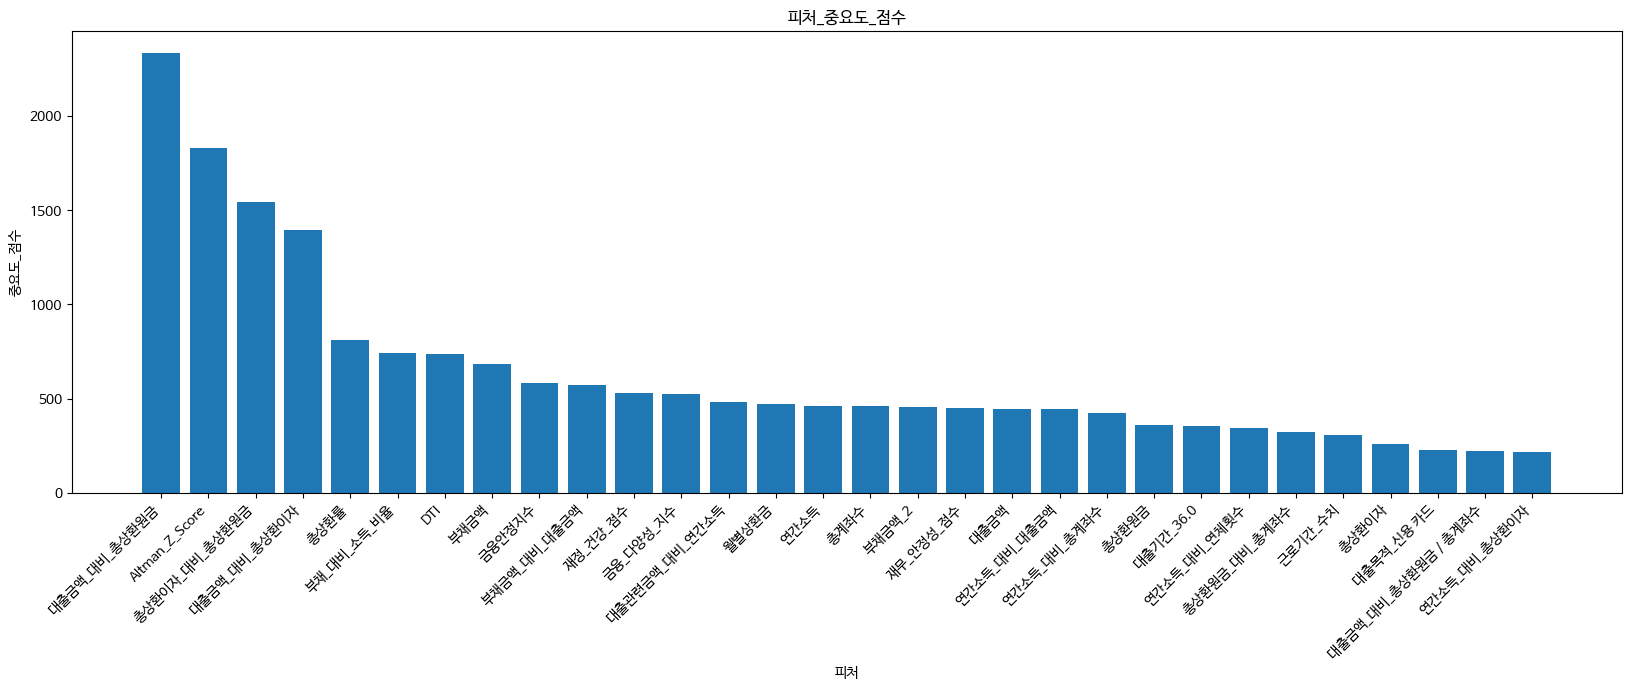

In [ ]:
# 특성 중요도를 기준으로 정렬된 인덱스 가져오기
sorted_indices = feature_importance.argsort()[::-1][:30]

# 정렬된 인덱스를 사용하여 선택된 특성 추출
selected_features = train_ft.columns[sorted_indices]

# 특성 중요도 시각화
plt.figure(figsize=(20, 6))
plt.bar(range(len(selected_features)), feature_importance[sorted_indices], tick_label=selected_features)
plt.title('피처_중요도_점수')
plt.xlabel('피처')
plt.ylabel('중요도_점수')
plt.xticks(rotation=45, ha='right')
plt.show()

- '대출금액_대비_총상환금'이 가장 높은 피처 중요도를 보이고 있음.

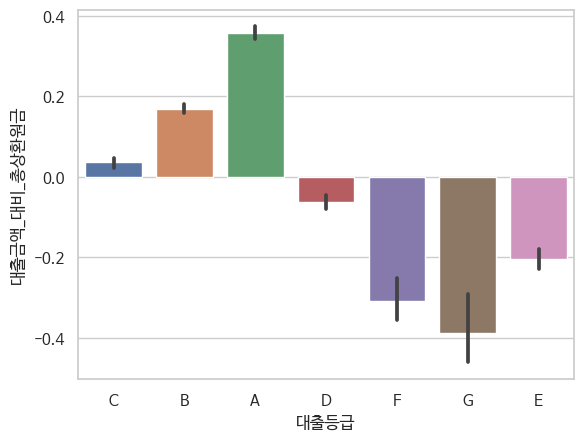

In [ ]:
sns.barplot(x = '대출등급',y = '대출금액_대비_총상환원금',data = train_data)
plt.show()

In [ ]:
train_data['대출금액_대비_총상환원금'].min()
# 튜닝해서 -가 나와버림

-0.9463985078375564

# pycaret[full]

In [ ]:
!pip install pycaret[full]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cols = ['근로기간','대출기간','주택소유상태','대출목적','연체계좌수','최근_2년간_연체_횟수']
enc = OneHotEncoder(handle_unknown = 'ignore')

# 학습 데이터
tmp = pd.DataFrame(
    enc.fit_transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
# 테스트 데이터
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

In [ ]:
X = train_ft.drop(['ID', '대출등급'], axis=1)
y= train_ft['대출등급']
Y = test_ft.drop(['ID'], axis=1)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

Y_scaled = scaler.transform(Y)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns)

In [ ]:
X_scaled['target']=target

In [ ]:
from pycaret.classification import *
# include=['lightgbm', 'xgboost', 'catboost', 'gbc', 'rf', 'et', 'ada', 'dt', 'knn', 'nb', 'lr']
# PyCaret 설정 초기화
clf = setup(data=X_scaled, target='target', session_id=123,
            use_gpu=True, # GPU 사용 활성화
            fold_strategy='stratifiedkfold', # 교차 검증 전략
            fold=5) # 10겹 교차 검증

# 모델 비교 (15개 모델 포함, 5겹 교차 검증 사용, ROC AUC로 정렬)
best_model = compare_models(n_select=6, include=['lightgbm', 'xgboost', 'catboost', 'gbc', 'rf', 'et', 'ada', 'dt', 'knn', 'nb', 'lr'],
                            cross_validation=True, sort='F1')

# 최고의 모델 출력
print(best_model)
#lr	Logistic Regression	0.7365	0.7905	0.6024	0.6890	0.6426	0.4354	0.4380	0.2560
#lr	Logistic Regression	0.7356	0.7907	0.6012	0.6878	0.6414	0.4335	0.4361	0.2400
#lr	Logistic Regression	0.7343	0.7914	0.5995	0.6857	0.6396	0.4306	0.4332	0.2660
#gbc	Gradient Boosting Classifier	0.7360	0.7922	0.5995	0.6890	0.6411	0.4339	0.4365	20.5840

In [ ]:
train_data.columns

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액',
       '연간소득_대비_대출금액', '대출금액_대비_총상환원금', '대출금액_대비_총상환이자', '대출금액_대비_총연체금액',
       '근로기간_수치', 'Altman_Z_Score', '대출금액_분위수', '월별상환금', 'DTI', '부채금액_2',
       '부채금액', '부채금액_대비_대출금액', '연간소득_분위수', '연간소득_대비_총상환원금', '연간소득_대비_총상환이자',
       '연간소득_대비_연체계좌수', '연간소득_대비_연체횟수', '연간소득_대비_총계좌수', '총상환이자_대비_총상환원금',
       '총상환원금_대비_총연체금액', '총상환원금_대비_총계좌수', '대출금액_대비_총상환원금 / 총계좌수', '근로기간_0',
       '근로기간_1 year', '근로기간_10+ years', '근로기간_2 years', '근로기간_3 years',
       '근로기간_4 years', '근로기간_5 years', '근로기간_6 years', '근로기간_7 years',
       '근로기간_8 years', '근로기간_9 years', '근로기간_< 1 year', '대출기간_36.0',
       '대출기간_60.0', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타',
       '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사',
       '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선',
       '대출목적_휴가', '연체계좌수_0.0', '연체계좌수_1.0', '연체계좌수_2.0', '연체계좌수_4.0',
       '최근_2년간_연체_횟수_0', '최근_2년간_연체_횟수_1', '최근

In [ ]:
# XGB
# parameters: {'max_depth': 19, 'learning_rate': 0.07656446152037562, 'subsample': 0.9123108476594585, 'colsample_bytree': 0.8694185489692836, 'min_child_weight': 2}
# 0.927
# parameters: {'max_depth': 19, 'learning_rate': 0.07340030539712863, 'subsample': 0.9018340261745573, 'colsample_bytree': 0.8645120190797543, 'min_child_weight': 2}
# 0.926